LDA Accuracy = 97.0
QDA Accuracy = 96.0


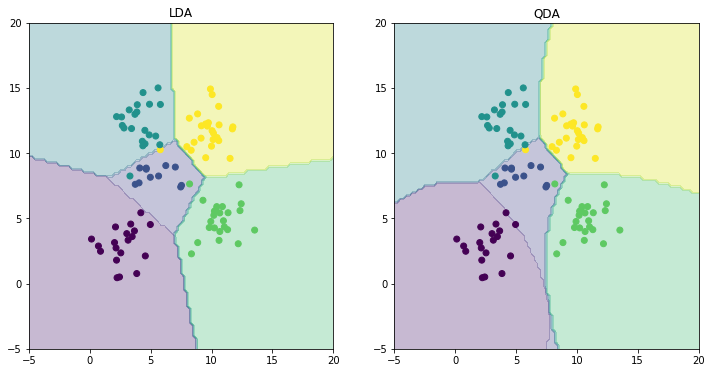

MSE without intercept [ 106775.36153868]
MSE with intercept [ 3707.84018117]
MSE without intercept Training Data[ 19099.44684457]
MSE with intercept Training Data[ 2187.16029493]


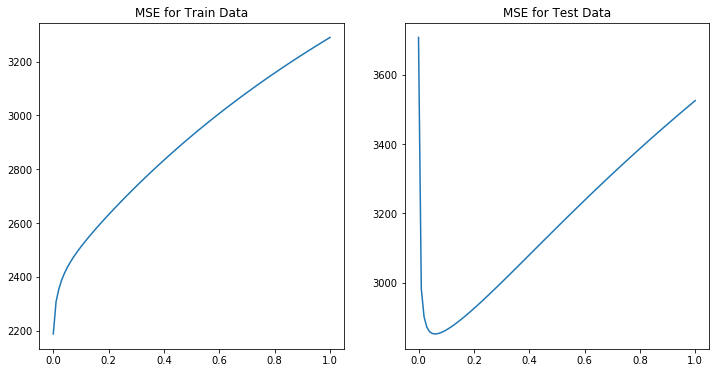

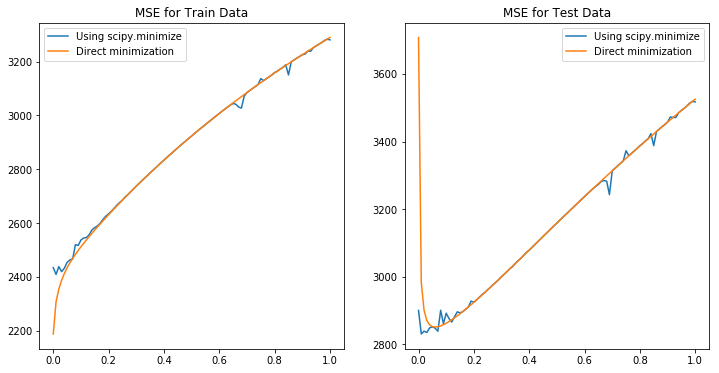

5650.71190703
3951.83912356
3950.68731238
3950.68253152
3950.6823368
3950.68233518
3950.68233514


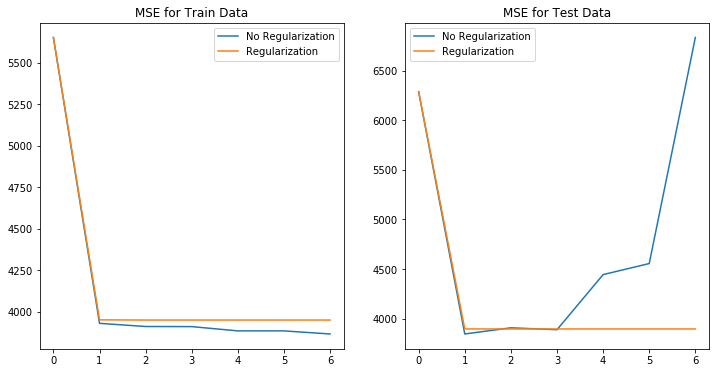

In [153]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys

def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix 
    
    # IMPLEMENT THIS METHOD

    class_matrix = np.unique(y).astype(int)
    features = np.shape(X)[1]
    means = np.zeros((features, class_matrix.size));
    covmat = np.zeros((features, features))
    for i in class_matrix:
        trainingData_X = X[np.where(y == i)[0],:]
        means[:, i-1] = np.mean(trainingData_X, 0).T
        covmat = covmat + np.cov(trainingData_X.T)
        
    return means,covmat

def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes
    
    # IMPLEMENT THIS METHOD

    class_matrix = np.unique(y).astype(int)
    features = np.shape(X)[1]
    means = np.zeros((features, class_matrix.size));
    covmats = []
    for i in class_matrix:
        trainingData_X = X[np.where(y==i)[0],:]
        means[:, i-1] = np.mean(trainingData_X, 0).T
        covmats.append(np.cov(trainingData_X.T))
    return means,covmats

def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD

    class_matrix = np.unique(y).astype(int)
    prediction = np.zeros((np.shape(Xtest)[0],1))
    divider = np.sqrt(np.pi*2 * np.linalg.det(covmat))
    value = 0.0;
    for i in range(0, Xtest.shape[0]):
        pdf1 = 0;
        for j in class_matrix:
            exponent = np.exp((-0.5)*(np.dot(np.dot((Xtest[i,:].T - means[:, j-1]).T, np.linalg.inv(covmat)), (Xtest[i,:].T - means[:, j-1]).T)))
            pdf2 = exponent/divider
            if pdf2 > pdf1:
                pdf1 = pdf2
                predictedClass = j
        prediction[i] = predictedClass

    for i in range(0, prediction.shape[0]):
        if prediction[i] == ytest[i]:
            value = value + 1
    accuracy = (value / Xtest.shape[0]) * 100
    yprediction = prediction.T
    return accuracy,yprediction

def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD

    class_matrix = np.unique(y).astype(int)
    prediction = np.zeros((np.shape(Xtest)[0],1))
    divider = np.zeros(class_matrix.size)
    value = 0.0
    for i in class_matrix:
        D = np.shape(covmats[i-1])[0]
        divider[i-1] = np.power(2*np.pi, D/2)*np.sqrt(np.linalg.det(covmats[i-1]))

    for i in range (0, np.shape(Xtest)[0]):
        pdf1 = 0
        for j in class_matrix:
            exponent = np.exp((-0.5)*(np.dot(np.dot((Xtest[i,:].T - means[:, j-1]).T, np.linalg.inv(covmats[j-1])), (Xtest[i,:].T - means[:, j-1]).T)))
            pdf2 = exponent / divider[j - 1]
            if pdf2 > pdf1:
                pdf1 = pdf2
                predictedClass = j
        prediction[i] = predictedClass

    for i in range(0, prediction.shape[0]):
        if prediction[i] == ytest[i]:
            value = value + 1;
    accuracy = (value / np.shape(Xtest)[0]) * 100
    yprediction = prediction.T
    return accuracy,yprediction

def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    
    # IMPLEMENT THIS METHOD
    mse1 = 0
    N = Xtest.shape[0]
    for i in range(0,N):
        y_i = ytest[i]
        w_T  = w.T
        x_i = Xtest[i]
        mse1 = mse1 + np.square(y_i - np.dot(w_T,x_i))

    mse = mse1/N
    return mse

def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d                                                               
    # y = N x 1 
    # lambd = ridge parameter (scalar)
    # Output:                                                                  
    # w = d x 1                                                                
    # IMPLEMENT THIS METHOD  
    C = X.T.dot(X) + lambd*np.eye(X.shape[1])
    w = inv(C).dot(X.T.dot(y))
        
    return w


def learnOLERegression(X,y):
    # Inputs:                                                         
    # X = N x d 
    # y = N x 1                                                               
    # Output: 
    # w = d x 1 
	
    # IMPLEMENT THIS METHOD      
    a = np.dot(X.T,X)
    c = np.linalg.inv(a)
    b = np.dot(X.T,y)
    w = np.dot(c,b)
    return w

def regressionObjVal(w, X, y, lambd):

    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda                                                                  
 
    # IMPLEMENT THIS METHOD   
    #a = y-X.dot(w)
    #b = w.T.dot(w)
    #error = 0.5*a.T.dot(a) + 0.5*lambd*b
    #print error
    #c = X.T.dot(X)
    #d = w.T.dot(c.T)
    #e = y.T.dot(X)
    #error_grad = d-e
        
    w = w.reshape(-1,1)

    a = y - np.dot(X,w)
    b = np.transpose(a)

    c = np.dot(b,a)
    d = lambd * np.dot(w.T,w)

    error = 0.5*(c + d)

    f = np.dot(X.T,X)
    g = np.dot(X.T,y)
    h = np.dot(f,w)

    error_grad = h - g + lambd*w
    error_grad = error_grad.flatten()
    return error, error_grad


def mapNonLinear(x,p):
    # Inputs:                                                                  
    # x - a single column vector (N x 1)                                       
    # p - integer (>= 0)                                                       
    # Outputs:                                                                 
    # Xp - (N x (p+1)) 
	
    # IMPLEMENT THIS METHOD
   
    Xd = np.ones((x.shape[0], p + 1))
    for i in range(1, p + 1):
        Xd[:, i] = x ** i
    
    return Xd

# Problem 1
# load the sample data                                                                 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.flatten())
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.flatten())
plt.title('QDA')

plt.show()

if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

#Problem 2
w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)
mle_tr = testOLERegression(w,X,y)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)
mle_i_tr = testOLERegression(w_i,X_i,y)

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))
print('MSE without intercept Training Data'+str(mle_tr))
print('MSE with intercept Training Data'+str(mle_i_tr))

# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
min_mse=0
opt_lambd=0
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    #print mses3_train[i]
    if i==0:
        min_mse=mses3[i]
    if mses3[i] < min_mse:
        min_mse=mses3[i]
        opt_lambd=lambd
    i = i + 1
    

#print  opt_lambd   
#print mses3
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.show()

# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.                                                
w_init = np.ones((X_i.shape[1],1))
min_mse=0
opt_lambd=0
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    if i==0:
        min_mse=mses3[i]
    if mses4[i] < min_mse:
        min_mse=mses4[i]
        opt_lambd=lambd
    i = i + 1
    #print lambd

#print  opt_lambd   
#print mses4
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()

#Problem 5
pmax = 7
lambda_opt = 0.06 # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    print(mses5_train[p,1])
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)
    #print("mses5",p,":")
    #print(mses5[p,1])
    
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()



MSE without intercept [ 106775.36153868]
MSE with intercept [ 3707.84018117]
MSE without intercept Training Data[ 19099.44684457]
MSE with intercept Training Data[ 2187.16029493]


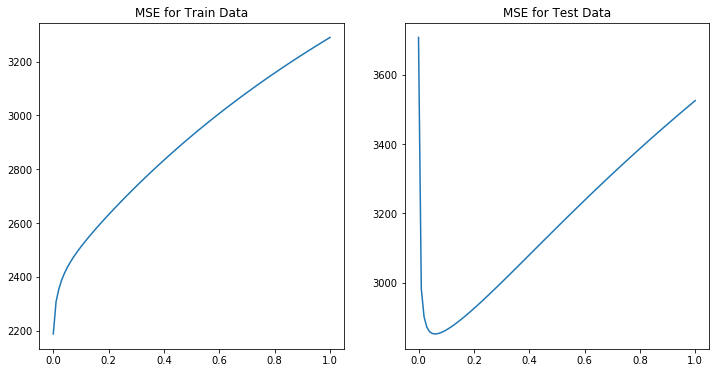

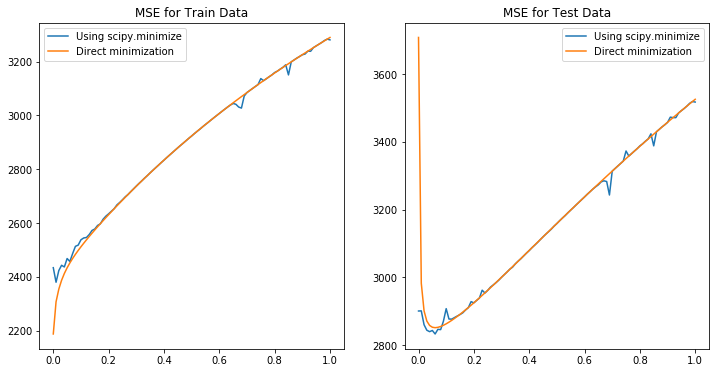

5650.71190703
3951.83912356
3950.68731238
3950.68253152
3950.6823368
3950.68233518
3950.68233514


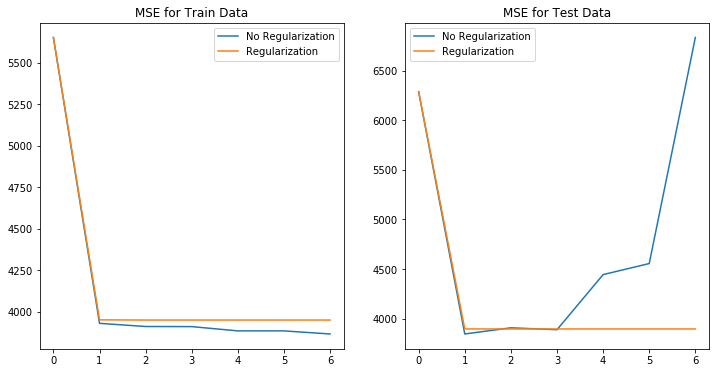